Coupling map:


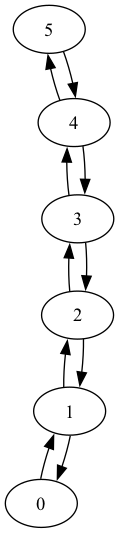

In [2]:
from gate_level.spillover_noise_use_case.generic_spillover.spillover_effect_on_subsystem import (
    LocalSpilloverNoiseAerPass,
    circuit_context,
    numpy_to_hashable,
    noisy_backend,
)
from qiskit.circuit import QuantumCircuit, ParameterVector
from qiskit.transpiler import PassManager, CouplingMap
import numpy as np
import matplotlib.pyplot as plt

num_qubits = 6
rotation_axes = ["rx", "ry", "rx", "ry", "rx", "ry"]
rotation_parameters = ParameterVector("θ", num_qubits)
cm = CouplingMap.from_line(num_qubits, True)
print("Coupling map:")
cm.draw()

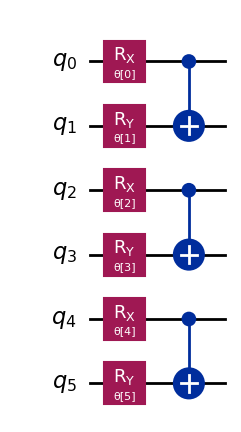

In [3]:
circuit = circuit_context(
    num_qubits, rotation_axes, rotation_parameters, coupling_map=cm
)
circuit.draw("mpl")

Parameter dictionary:
 {ParameterVectorElement(θ[0]): 2.274059027930055, ParameterVectorElement(θ[1]): 6.035613025233869, ParameterVectorElement(θ[2]): 0.47125171672594734, ParameterVectorElement(θ[3]): 4.834593626192009, ParameterVectorElement(θ[4]): 1.7739602577927625, ParameterVectorElement(θ[5]): 0.4315031512992537}


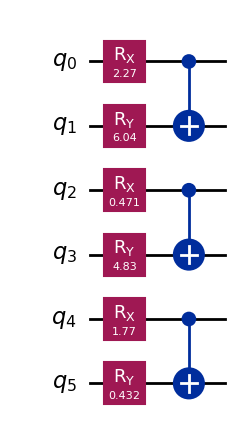

In [4]:
rotation_angles = np.random.uniform(0, 2 * np.pi, num_qubits)
param_dict = {theta: val for theta, val in zip(rotation_parameters, rotation_angles)}
print("Parameter dictionary:\n", param_dict)
circuit.assign_parameters(param_dict).draw("mpl")

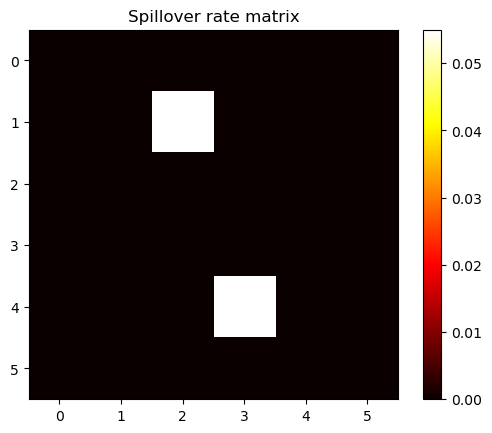

In [5]:
# Define noise-coupling matrix with gamma values (example values)
gamma_matrix = np.zeros((num_qubits, num_qubits))
gamma_matrix[0, 1] = 0.00  # γ_0->1
gamma_matrix[0, 3] = 0.0  # γ_0->3
gamma_matrix[1, 2] = 0.055  # γ_1->2
gamma_matrix[2, 3] = 0.0  # γ_2->3
gamma_matrix[3, 2] = 0.0  # γ_3->2
gamma_matrix[4, 3] = 0.055  # γ_4->3
gamma_matrix[5, 4] = 0.00  # γ_5->4

# Display gamma matrix with imshow plot for better visualization
plt.imshow(gamma_matrix, cmap="hot", interpolation="nearest")
plt.colorbar()
plt.title("Spillover rate matrix")
plt.show()

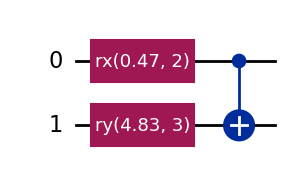

In [6]:
pm = PassManager(
    [
        LocalSpilloverNoiseAerPass(
            spillover_rate_matrix=numpy_to_hashable(gamma_matrix),
            target_subsystem=(2, 3),
        )
    ]
)
qc_noisy = pm.run(circuit.assign_parameters(param_dict))
qc_noisy.draw("mpl")

In [7]:
backend = noisy_backend(
    circuit.assign_parameters(param_dict),
    gamma_matrix,
    target_subsystem=(2, 3),
)

In [8]:
print("Rotation angles:", rotation_angles)

Rotation angles: [2.27405903 6.03561303 0.47125172 4.83459363 1.77396026 0.43150315]


In [9]:
backend.options.noise_model.to_dict()

{'errors': [{'type': 'qerror',
   'id': '5283804893344a56a25d16a5c1ceb11f',
   'operations': ['rx(0.47, 2)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[ 0.98625702+0.j, -0.16521831+0.j],
              [ 0.16521831+0.j,  0.98625702+0.j]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(0,)]},
  {'type': 'qerror',
   'id': '478c68f9cee7463e87a7ec29742e77bd',
   'operations': ['ry(4.83, 3)'],
   'instructions': [[{'name': 'unitary',
      'qubits': [0],
      'params': [array([[0.9988103+0.j        , 0.       -0.04876456j],
              [0.       -0.04876456j, 0.9988103+0.j        ]])]}]],
   'probabilities': [1.0],
   'gate_qubits': [(1,)]}]}

In [10]:
from qiskit.quantum_info import Operator

Operator(qc_noisy)

Operator([[-0.72827107+0.j        ,  0.        +0.17484735j,
           -0.64429931+0.j        ,  0.        +0.15468695j],
          [ 0.        -0.15468695j,  0.64429931+0.j        ,
            0.        +0.17484735j, -0.72827107+0.j        ],
          [ 0.64429931+0.j        ,  0.        -0.15468695j,
           -0.72827107+0.j        ,  0.        +0.17484735j],
          [ 0.        +0.17484735j, -0.72827107+0.j        ,
            0.        +0.15468695j, -0.64429931+0.j        ]],
         input_dims=(2, 2), output_dims=(2, 2))


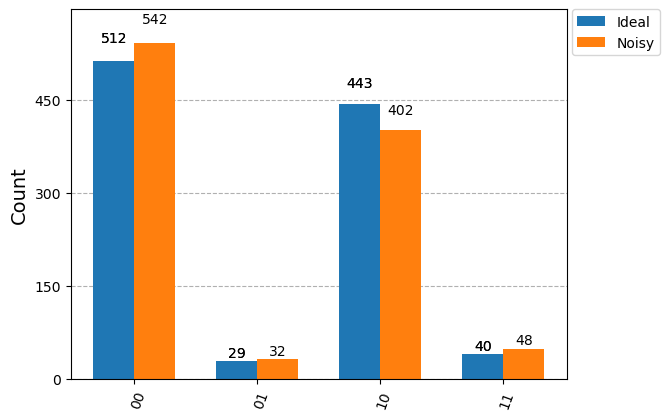

In [11]:
from qiskit.providers.basic_provider import BasicSimulator
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_histogram

ideal_backend = AerSimulator()

ideal_result = ideal_backend.run(qc_noisy.measure_all(inplace=False)).result()
noisy_result = backend.run(qc_noisy.measure_all(inplace=False)).result()

ideal_counts = ideal_result.get_counts()
noisy_counts = noisy_result.get_counts()

plot_histogram([ideal_counts, noisy_counts], legend=["Ideal", "Noisy"])

In [12]:
# Compute fidelities
from qiskit.quantum_info import state_fidelity, average_gate_fidelity

qc_noisy_ideal_state = qc_noisy.copy()
qc_noisy_state = qc_noisy.copy()
# qc_noisy_ideal_state.save_statevector()
qc_noisy_ideal_state.save_unitary()
# qc_noisy_state.save_statevector()
qc_noisy_state.save_unitary()

# ideal_state = ideal_backend.run(qc_noisy_ideal_state).result().get_statevector()
# noisy_state = backend.run(qc_noisy_state).result().get_statevector()
ideal_unitary = ideal_backend.run(qc_noisy_ideal_state).result().get_unitary()
noisy_unitary = backend.run(qc_noisy_state).result().get_unitary()

In [13]:
output_fidelity = average_gate_fidelity(ideal_unitary, noisy_unitary)
output_fidelity

0.976311872091587

In [14]:
from qiskit import QuantumRegister
from rl_qoc.helpers import get_gate

# Add here custom ansatz CX gate


def apply_parametrized_circuit(
    qc: QuantumCircuit, params: ParameterVector, q_reg: QuantumRegister, **kwargs
):
    """
    Define ansatz circuit to be played on Quantum Computer. Should be parametrized with qiskit_pulse ParameterVector
    This function is used to run the QuantumCircuit instance on a Runtime backend
    :param qc: Quantum Circuit instance to add the gate on
    :param params: Parameters of the custom Gate
    :param q_reg: Quantum Register formed of target qubits
    :return:
    """
    target = kwargs["target"]
    my_qc = QuantumCircuit(q_reg, name=f"{get_gate(target['gate']).name}_cal")
    optimal_params = np.pi * np.array([0.0, 0.0, 0.5, 0.5, -0.5, 0.5, -0.5])
    # optimal_params = np.pi * np.zeros(len(params))

    my_qc.u(
        optimal_params[0] + params[0],
        optimal_params[1] + params[1],
        optimal_params[2] + params[2],
        q_reg[0],
    )
    my_qc.u(
        optimal_params[3] + params[3],
        optimal_params[4] + params[4],
        optimal_params[5] + params[5],
        q_reg[1],
    )

    my_qc.rzx(optimal_params[6] + params[6], q_reg[0], q_reg[1])
    qc.append(my_qc.to_instruction(label=my_qc.name), q_reg)

In [15]:
# Define the environment
from gymnasium.spaces import Box
from gymnasium.wrappers import ClipAction
from rl_qoc import (
    QEnvConfig,
    ExecutionConfig,
    ContextAwareQuantumEnvironment,
    QiskitConfig,
)

action_space = Box(low=-np.pi, high=np.pi, shape=(7,), dtype=np.float32)
target = {"gate": "cnot", "physical_qubits": [0, 1]}

backend_config = QiskitConfig(
    apply_parametrized_circuit,
    backend=backend,
    skip_transpilation=False,
    parametrized_circuit_kwargs={"target": target, "backend": backend},
)
q_env_config = QEnvConfig(
    backend_config=backend_config,
    target=target,
    action_space=action_space,
    execution_config=ExecutionConfig(
        batch_size=64,
        n_reps=8,
        n_shots=1000,
        sampling_paulis=500,
    ),
    reward_config="channel",
)
q_env = ContextAwareQuantumEnvironment(
    q_env_config,
    circuit_context=qc_noisy,  # Pass the circuit already transpiled through custom pass
)
rescaled_env = ClipAction(q_env)

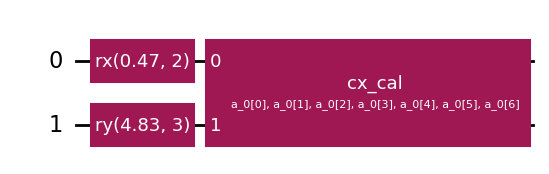

In [16]:
q_env.circuits[0].draw(output="mpl")

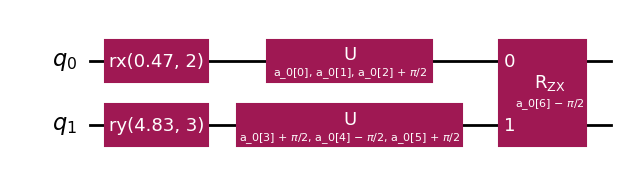

In [17]:
q_env.backend_info.custom_transpile(q_env.circuits[0]).draw("mpl")

In [20]:
q_env.simulate_circuit(q_env.circuits[0], np.zeros((1, 7)), False)

[0.9763118720915868]

In [21]:
from rl_qoc.helpers import load_from_yaml_file

# Change the file_name to the name of the agent configuration file and specify the file location
file_name = "agent_config.yaml"
file_location = file_name

agent_config = load_from_yaml_file(file_location)

In [22]:
from rl_qoc.agent import CustomPPO, TrainingConfig, TrainFunctionSettings, TotalUpdates

ppo_agent = CustomPPO(agent_config, rescaled_env)
total_updates = 500
target_fidelities = [0.999]
lookback_window = 20
anneal_learning_rate = False

ppo_config = TrainingConfig(
    TotalUpdates(total_updates),
    target_fidelities,
    lookback_window,
    anneal_learning_rate,
)
train_settings = TrainFunctionSettings(
    plot_real_time=True,
    print_debug=False,
    num_prints=10,
    hpo_mode=False,
    clear_history=True,
)

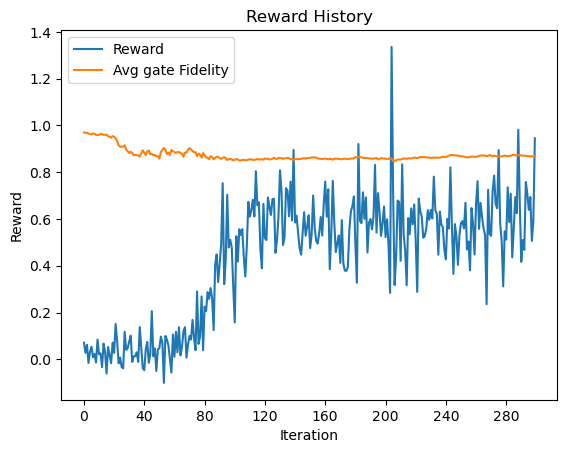

Starting simulation benchmark...
Finished simulation benchmark 

Fidelities:  0.8687865964128368
Sending Estimator job...


<Figure size 640x480 with 0 Axes>

In [23]:
%matplotlib inline
ppo_agent.train(ppo_config, train_settings)

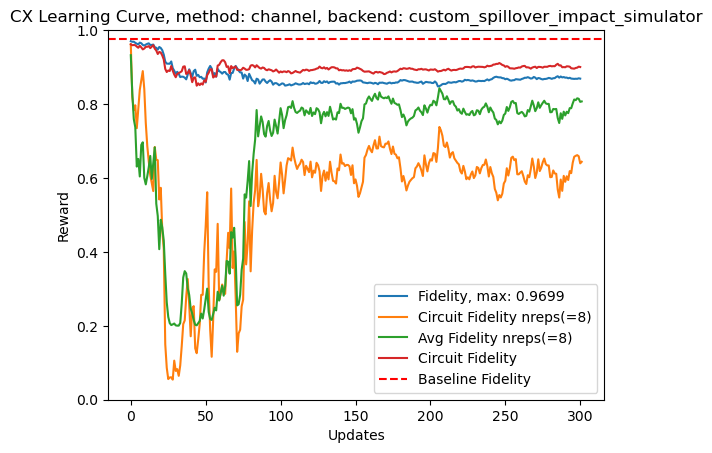

In [24]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

# plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(
    q_env.circuit_fidelity_history_nreps,
    label=f"Circuit Fidelity nreps(={q_env.n_reps})",
)
plt.plot(q_env.avg_fidelity_history_nreps, label=f"Avg Fidelity nreps(={q_env.n_reps})")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.axhline(
    q_env.simulate_circuit(q_env.circuits[0], np.zeros((1, 7))),
    label="Baseline Fidelity",
    color="red",
    linestyle="--",
)
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.ylim(0.0, 1.0)
plt.legend()
plt.show()

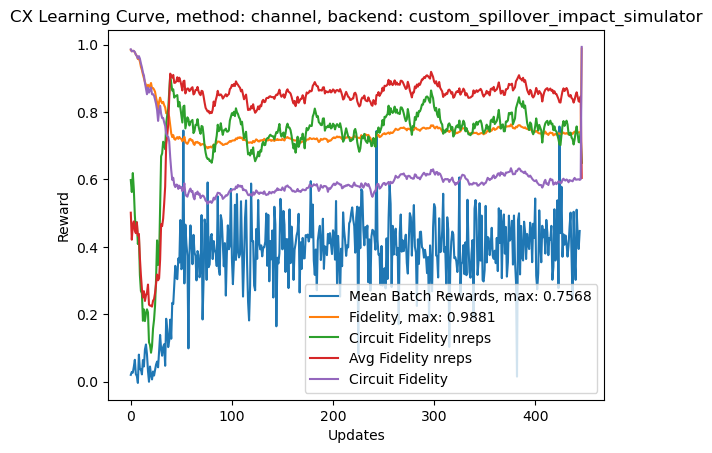

In [32]:
# Plotting the learning curve

reward_history = np.array(q_env.reward_history)
mean_rewards = np.mean(reward_history, axis=-1)
max_mean = int(np.max(mean_rewards) * 1e4) / 1e4

plt.plot(mean_rewards, label=f"Mean Batch Rewards, max: {max_mean}")
plt.plot(
    q_env.fidelity_history,
    label=f"Fidelity, max: {int(np.max(q_env.fidelity_history) * 1e4) / 1e4}",
)
plt.plot(q_env.circuit_fidelity_history_nreps, label="Circuit Fidelity nreps")
plt.plot(q_env.avg_fidelity_history_nreps, label="Avg Fidelity nreps")
plt.plot(q_env.circuit_fidelity_history, label="Circuit Fidelity")
plt.xlabel("Updates")
plt.ylabel("Reward")
plt.title(
    f"{q_env.target.gate.name.upper()} Learning Curve, method: {q_env.config.reward_method},"
    f" backend: {q_env_config.backend.name if q_env_config.backend is not None else 'No backend'}"
)
plt.legend()
plt.show()

In [25]:
q_env.optimal_action

array([ 0.3911596 , -0.24494173, -0.2785439 , -0.10709168, -0.47818178,
        0.11871637, -0.07771585], dtype=float32)

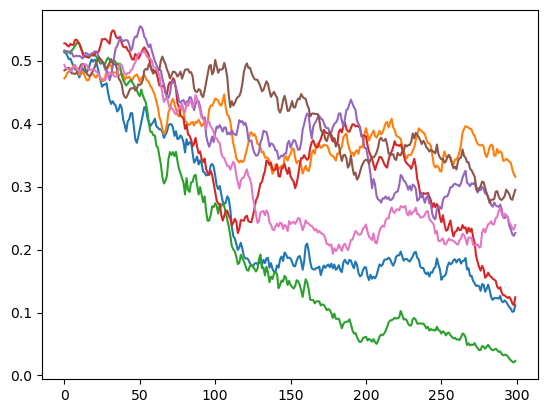

In [35]:
plt.plot(ppo_agent.training_results["std_action"])